In [16]:
import numpy as np 
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import os
from scipy.signal import savgol_filter
from simulation import detect_intersect
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
device = 'cuda' if torch.cuda.is_available() else 'cpu'

sample = np.load('sample.npy')

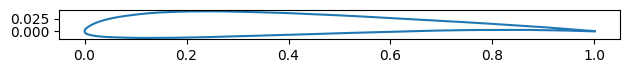

In [10]:
i = 1
xhat, yhat = savgol_filter((sample[i,:,0], sample[i,:,1]), 10, 3)
fig, axs = plt.subplots(1, 1)
axs.plot(xhat, yhat)
axs.set_aspect('equal', 'box')
fig.tight_layout()
plt.show()

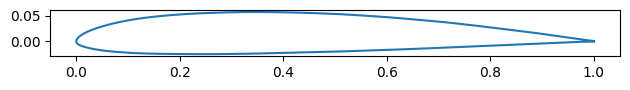

In [30]:
i = 35
xhat, yhat = savgol_filter((sample[i,:,0], sample[i,:,1]), 10, 3)
fig, axs = plt.subplots(1, 1)
axs.plot(xhat, yhat)
axs.set_aspect('equal', 'box')
fig.tight_layout()
plt.show()

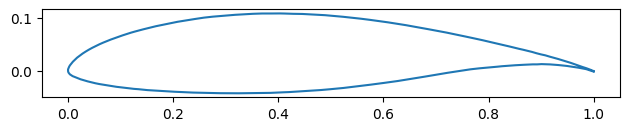

In [24]:
alpha = 0.01
mutate = alpha * sample[1,:,:] + (1-alpha) * sample[2,:,:]

fig, axs = plt.subplots(1, 1)
axs.plot(mutate[:,0], mutate[:,1])
axs.set_aspect('equal', 'box')
fig.tight_layout()
plt.show()